### Cab-Driver Agent

In [19]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

import time

#### Defining Time Matrix

In [20]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [21]:
# Creating env object of the tictactoe class in the environment file 
env = CabDriver()
action_space, state_space, state_init = env.reset()

In [22]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [23]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor =0.95
        self.learning_rate =0.001 
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = 0.0009
        self.epsilon_min = 0.00001
        
        self.batch_size = 256        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        
        #tracking first state and random action 3 
        self.states_tracked = {'1-23-0':[],'0-14-1':[],'3-12-1':[],'0-0-0':[]}

    # approximate Q function using Neural Network
    def build_model(self):
        input_shape = self.state_size

        model = Sequential()
        
        # hidden layers
        model.add(Dense(32, input_dim=input_shape, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model


    def get_action(self, state):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        possible_actions_index,actions = env.requests(state)
        
        if np.random.rand() <= self.epsilon:
            action_index = random.choice(possible_actions_index)
            return action_index
        else:
            state = np.array(env.state_encod_arch1(state)).reshape(1,36)
            q_value = self.model.predict(state)
            q_value_selected = [q_value[0][i] for i in possible_actions_index]
           
            action_index = possible_actions_index[np.argmax(q_value_selected)]
            return action_index
        

    def append_sample(self, state, action, reward, next_state,done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state,action,reward,next_state,done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size,self.state_size))
            update_input =  np.zeros((self.batch_size,self.state_size))
            
            actions, rewards,done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_value = mini_batch[i]
                update_input[i]= np.array(env.state_encod_arch1(state)).reshape(1,36)
                actions.append(action)
                rewards.append(reward)
                update_output[i]= np.array(env.state_encod_arch1(next_state)).reshape(1,36)
                done.append(done_value)
                
            # Write your code from here
            # 1. Predict the target from earlier model    
            target = self.model.predict(update_input)
            # 2. Get the target for the Q-network
            target_val = self.model.predict(update_output)    
            
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]]= rewards[i] + self.discount_factor*(np.max(target_val[i]))
                
            # 4. Fit your model and track the loss values
            #self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)    
            self.model.fit(update_input, target,verbose =0)    
        
    def save_tracking_states(self):
        
        #tracking the first state and randomly sleected action index 2
        for tracked_state,values in self.states_tracked.items():
            enc_state = [int(i) for i in tracked_state.split('-')]
            enc_state = np.array(env.state_encod_arch1(enc_state)).reshape(1,36)
            q_value = self.model.predict(enc_state)
            self.states_tracked[tracked_state].append(q_value[0][2])
        
    def save(self, name):
        self.model.save(name)
        

### DQN block

In [24]:
m= 5
t= 24
d =7

env = CabDriver()
action_space, state_space, state = env.reset()

state_size= m+t+d
action_size = len(action_space)

agent = DQNAgent(state_size,action_size)

agent.model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 21)                693       
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [25]:
#number of episodes
Episodes = 10000

#every these many episodes, the Q-values will be stored/appended (convergence graphs)
q_threshold = 10
h5_threshold = 2000

In [26]:
reward_earned,episodes = [],[]

start_time= time.time()

track_state = []
for episode in range(Episodes):
    
    # Write code here
    done = False
    
    # Call the environment
    # Call all the initialised variables of the environment
    env = CabDriver()
    action_space, state_space, state = env.reset()
        
    total_time = 0
    rewards = 0
    
    #Call the DQN agent
    count = 0 
    
    while not done:
        count+=1
        
        action = agent.get_action(state)
        reward = env.reward_func(state, action_space[action], Time_matrix)
        next_state,done = env.next_state_func(state, action_space[action], Time_matrix)
        
        agent.append_sample(state, action, reward, next_state,done)
        
        if count % 20 == 0: #To reduce the training time we will train the model intermittently
            agent.train_model()
        
        rewards += reward
        state = next_state
        
    reward_earned.append(rewards)
    episodes.append(episode)
    
    #if agent.epsilon_min < agent.epsilon:
    agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(-agent.epsilon_decay*episode)
    
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory {2}, epsilon {3}".format(episode,
                                                                         rewards,
                                                                         len(agent.memory),
                                                                         agent.epsilon))
    
    
    #TRACKING Q-VALUES
    if ((episode+1) % q_threshold) == 0:   #Trackin Q values 
        agent.save_tracking_states()
        save_obj(agent.states_tracked,'States_tracked')
        
    #Saving model weights
    if ((episode+1) % h5_threshold) == 0:   #Saving model weights
        agent.save(name="Cab_Book_DeepRL.h5")
        
elapsed_time = time.time() - start_time
save_obj(agent.states_tracked,'States_tracked')   
print(elapsed_time)


episode 9, reward 60, memory 939, epsilon 0.9919327972784051
episode 19, reward -199, memory 1834, epsilon 0.9830455447282489
episode 29, reward -31, memory 2000, epsilon 0.9742379185946918
episode 39, reward -91, memory 2000, epsilon 0.9655092054552015
episode 49, reward -66, memory 2000, epsilon 0.9568586982792411
episode 59, reward -86, memory 2000, epsilon 0.9482856963709998
episode 69, reward -125, memory 2000, epsilon 0.9397895053126356
episode 79, reward -26, memory 2000, epsilon 0.9313694369080276
episode 89, reward -2, memory 2000, epsilon 0.9230248091270313
episode 99, reward 111, memory 2000, epsilon 0.9147549460502341
episode 109, reward 17, memory 2000, epsilon 0.9065591778142049
episode 119, reward -100, memory 2000, epsilon 0.8984368405572359
episode 129, reward -123, memory 2000, epsilon 0.8903872763655684
episode 139, reward -124, memory 2000, epsilon 0.8824098332201014
episode 149, reward 52, memory 2000, epsilon 0.8745038649435786
episode 159, reward -94, memory 2000

In [27]:
#Verifying States tracked
agent.states_tracked

{'1-23-0': [0.817403,
  20.05088,
  51.028522,
  77.25813,
  102.61321,
  128.44228,
  147.02786,
  173.06395,
  199.31018,
  227.7272,
  247.90852,
  254.49582,
  266.14392,
  280.45206,
  298.9335,
  311.4707,
  329.5292,
  357.5659,
  379.85217,
  389.77295,
  386.67734,
  383.25934,
  383.533,
  392.77798,
  391.95645,
  388.73425,
  384.55408,
  372.75504,
  380.66486,
  383.35144,
  391.93228,
  399.91895,
  403.015,
  401.83865,
  398.39172,
  412.62958,
  416.96487,
  411.50815,
  394.0629,
  379.38046,
  389.71762,
  403.08603,
  395.5232,
  389.4323,
  389.32416,
  392.15494,
  389.43756,
  390.2795,
  401.0951,
  385.4853,
  384.33478,
  389.1649,
  394.05444,
  409.88492,
  394.47842,
  377.58987,
  385.6671,
  384.00552,
  396.58572,
  408.51624,
  390.89334,
  403.6656,
  420.9534,
  414.4488,
  412.16486,
  411.0998,
  412.56903,
  404.7218,
  402.97678,
  405.6507,
  397.48407,
  395.6079,
  386.7745,
  383.126,
  371.547,
  372.73694,
  376.6968,
  368.8083,
  367.2947

In [28]:
#Veifying rewards tracked
reward_earned

[-158,
 -301,
 85,
 -295,
 -165,
 8,
 -288,
 -35,
 61,
 60,
 -80,
 -234,
 -196,
 77,
 -214,
 -139,
 1,
 -44,
 -147,
 -199,
 182,
 -17,
 -24,
 -80,
 -1,
 -125,
 -52,
 26,
 -27,
 -31,
 30,
 -32,
 -424,
 147,
 -338,
 -153,
 -71,
 -166,
 -194,
 -91,
 117,
 -115,
 -60,
 2,
 -155,
 22,
 -225,
 28,
 -31,
 -66,
 -189,
 -26,
 -241,
 -252,
 -164,
 -85,
 -223,
 -124,
 120,
 -86,
 -7,
 -263,
 -133,
 143,
 99,
 -169,
 -104,
 14,
 97,
 -125,
 208,
 -177,
 -120,
 -70,
 -65,
 66,
 34,
 -194,
 -19,
 -26,
 -34,
 -137,
 -172,
 221,
 -165,
 -190,
 22,
 203,
 6,
 -2,
 33,
 309,
 14,
 37,
 -131,
 -207,
 -271,
 -271,
 104,
 111,
 -290,
 29,
 194,
 46,
 75,
 55,
 35,
 -155,
 20,
 17,
 -116,
 -5,
 19,
 119,
 83,
 -17,
 -108,
 50,
 27,
 -100,
 61,
 28,
 -181,
 -34,
 -176,
 -75,
 234,
 34,
 217,
 -123,
 13,
 22,
 -56,
 13,
 79,
 -23,
 174,
 93,
 187,
 -124,
 219,
 341,
 222,
 64,
 158,
 68,
 140,
 132,
 -44,
 52,
 -256,
 146,
 125,
 -52,
 -52,
 -287,
 6,
 -41,
 5,
 -94,
 264,
 -148,
 162,
 163,
 47,
 -145,
 114,

### Tracking Convergence

**Convergence of States**

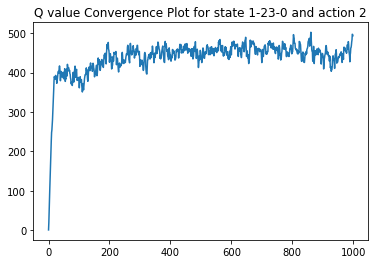

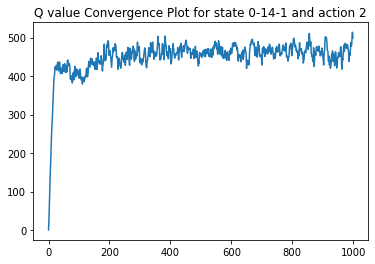

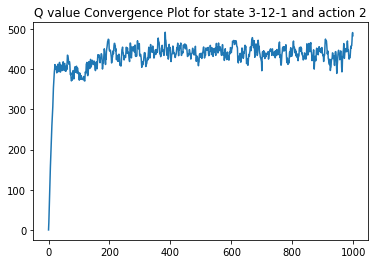

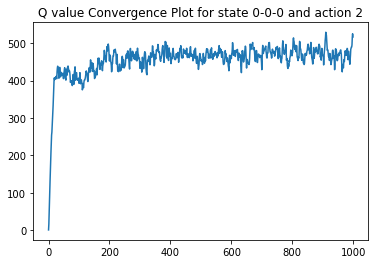

In [29]:
for i,values in agent.states_tracked.items():
    x_axis = np.arange(0,len(values))
    y_axis = np.asarray(values)
    plt.plot(x_axis,y_axis)
    plt.title("Q value Convergence Plot for state {} and action 2".format(i))
    plt.show()

**Convergence of Reward**

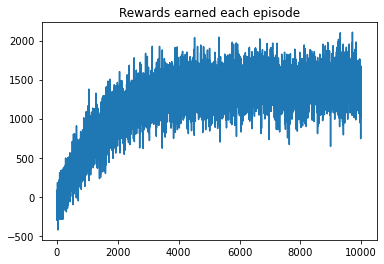

In [30]:
x_axis = np.arange(0,len(reward_earned))
y_axis = np.asarray(reward_earned)
plt.plot(x_axis,y_axis)
plt.title("Rewards earned each episode")
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [31]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

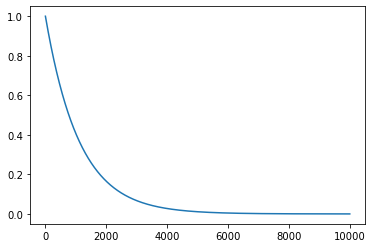

In [32]:
plt.plot(time, epsilon)
plt.show()